#### Imports

In [1]:
!pip install tqdm
!pip install imgaug
!pip install annoy

    100% |████████████████████████████████| 51kB 2.1MB/s 
    100% |████████████████████████████████| 563kB 5.9MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /content/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug
    100% |████████████████████████████████| 634kB 5.5MB/s 
  Running setup.py bdist_wheel for annoy ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/83/3f/c3/8487c918f081743343103163a5ac7b1f61677b71920cf3014a
Successfully built annoy


In [0]:
import os

# load files from local
from google.colab import files

import matplotlib.pyplot as plt 
import seaborn as sns
% matplotlib inline

import pandas as pd
import numpy as np
np.random.seed(7)

from tqdm import tqdm
import gc

import pickle

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

#### Check if files ar inplace

In [4]:
!rm download_images.py
!rm gcs_wrapper.py

rm: cannot remove 'download_images.py': No such file or directory
rm: cannot remove 'gcs_wrapper.py': No such file or directory


In [5]:
!gsutil cp gs://proj-ia/train.csv ./train.csv
!gsutil cp gs://proj-ia/download_images.py ./download_images.py
!gsutil cp gs://proj-ia/gcs_wrapper.py ./gcs_wrapper.py  

Copying gs://proj-ia/train.csv...
| [1 files][127.4 MiB/127.4 MiB]                                                
Operation completed over 1 objects/127.4 MiB.                                    
Copying gs://proj-ia/download_images.py...
/ [1 files][  4.4 KiB/  4.4 KiB]                                                
Operation completed over 1 objects/4.4 KiB.                                      
Copying gs://proj-ia/gcs_wrapper.py...
/ [1 files][  639.0 B/  639.0 B]                                                
Operation completed over 1 objects/639.0 B.                                      


In [6]:
ls -lh 


total 128M
drwxr-xr-x 1 root root 4.0K May  2 13:55 datalab/
-rw-r--r-- 1 root root 4.4K May  2 13:56 download_images.py
-rw-r--r-- 1 root root  639 May  2 13:56 gcs_wrapper.py
-rw-r--r-- 1 root root 128M May  2 13:56 train.csv


## Read Data

In [7]:
# open dataset
input_data = pd.read_csv('./train.csv')
input_data.shape

(1225029, 3)

In [8]:
input_data.head()

id                                                url  \
0  cacf8152e2d2ae60  http://static.panoramio.com/photos/original/70...   
1  0a58358a2afd3e4e  http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...   
2  6b2bb500b6a38aa0  http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...   
3  b399f09dee9c3c67  https://lh3.googleusercontent.com/-LOW2cjAqubA...   
4  19ace29d77a5be66  https://lh5.googleusercontent.com/-tnmSXwQcWL8...   

   landmark_id  
0         4676  
1         6651  
2        11284  
3         8429  
4         6231

In [9]:
url = input_data.iloc[0]['url']
print(url)

http://static.panoramio.com/photos/original/70761397.jpg


## Download images

In [0]:
DOWNLOAD_BUCKET_NAME = 'imgs256'
DOWNLOAD_DIR = 'input_data'
DOWNLOADER_NUM_WORKERS = 64
DOWNLOADER_TARGET_SIZE = 256

In [0]:
from download_images import init, run_on_batches

In [0]:
init(DOWNLOAD_BUCKET_NAME, DOWNLOAD_DIR, 
        DOWNLOADER_NUM_WORKERS, DOWNLOADER_TARGET_SIZE)

In [13]:
print('%s - %s' % (DOWNLOAD_BUCKET_NAME, DOWNLOADER_TARGET_SIZE))

imgs256 - 256


In [0]:
# run_on_batches(input_data, batches_num=100)

In [15]:
from gcs_wrapper import get_downloaded_ids
from download_images import IDS_DOWNLOADED, GLOBAL_BUCKET
if IDS_DOWNLOADED is None:
  IDS_DOWNLOADED = get_downloaded_ids(GLOBAL_BUCKET, DOWNLOAD_DIR)

1218787it [04:17, 4725.00it/s]


## Quick EDA

Remove examples with invalid download link

In [16]:
def get_invalid_ids(data, ids_downloaded):
  return {img_id for img_id in data['id'].values 
              if img_id not in ids_downloaded}

def df_filter(df, invalid_ids):
  return [v not in invalid_ids for v in df.values]
      
    
invalid_ids = get_invalid_ids(input_data, IDS_DOWNLOADED)
print('Number of exemples before %s' % input_data.count()['id'])
print('Number of examples with invalid link: %.2f%%' % (100 * (len(invalid_ids)/input_data.count()['id'])))
input_data = input_data[df_filter(input_data['id'], invalid_ids)]
print('Number of exemples after %s' % input_data.count()['id'])

Number of exemples before 1225029
Number of examples with invalid link: 0.51%
Number of exemples after 1218780


In [17]:
imgs_per_class = input_data.groupby('landmark_id').agg('count')['id']

print("Landmark ids stats")
imgs_per_class.describe()

Landmark ids stats


count    14951.000000
mean        81.518293
std        703.858845
min          1.000000
25%          6.000000
50%         14.000000
75%         46.000000
max      50110.000000
Name: id, dtype: float64

In [18]:
print("Classes with just 1 image: %.2f%%" % (100 * (sum(imgs_per_class == 1) / imgs_per_class.shape[0])))
print("Classes with just 2 image: %.2f%%" % (100 * (sum(imgs_per_class == 2) / imgs_per_class.shape[0])))
print("Classes with just 3 image: %.2f%%" % (100 * (sum(imgs_per_class == 3) / imgs_per_class.shape[0])))
print("Classes with more than 5 images: %.2f%%" % (100 * (sum(imgs_per_class > 5) / imgs_per_class.shape[0])))
print("Classes with more than 10 images: %.2f%%" % (100 * (sum(imgs_per_class > 10) / imgs_per_class.shape[0])))

Classes with just 1 image: 1.10%
Classes with just 2 image: 2.01%
Classes with just 3 image: 4.23%
Classes with more than 5 images: 77.09%
Classes with more than 10 images: 55.97%


Landmark ids distribution


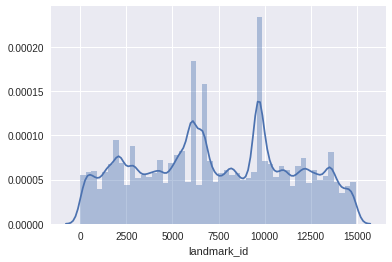

In [19]:
print("Landmark ids distribution")
sns.distplot(input_data['landmark_id'], kde=True);

In [20]:
print("Least frequent landmarks")
imgs_per_class.sort_values().head(10)

Least frequent landmarks


landmark_id
7815     1
10711    1
4144     1
9208     1
4103     1
2859     1
4753     1
5865     1
320      1
1033     1
Name: id, dtype: int64

In [21]:
print("Most frequent landmarks")
imgs_per_class.sort_values().tail(10)

Most frequent landmarks


landmark_id
2743     8967
5376     9178
6696     9180
6651     9468
5554    11066
2061    13217
9779    18348
6599    23284
6051    49920
9633    50110
Name: id, dtype: int64

### Quick EDA Images

#### Utils

In [0]:
def read_image(img_id, out_dir = './input_data'):
  x = plt.imread(os.path.join(out_dir, '{}.jpg'.format(img_id)))
  return x

def plot_imgs(imgs, rows, cols, names = None):
  if rows * cols < len(imgs):
    raise Exception()
  if not names is None and len(names) != len(imgs):
    raise Exception()
  plt.figure(figsize=(25,15))
  for i, img in enumerate(imgs):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.grid(False)
    if not names is None:
      plt.title(names[i])

In [0]:
print("Least frequent landmarks")
least_fq_lm_ids = imgs_per_class.sort_values().head(10).keys()
least_fq_lm_images = []
for lm_id in least_fq_lm_ids:
  least_fq_lm_images.append(read_image \
    (input_data[input_data['landmark_id'] == lm_id].iloc[0]['id']))
plot_imgs(least_fq_lm_images, 3, 4, least_fq_lm_ids)

Least frequent landmarks


FileNotFoundError: ignored

In [0]:
print("Most frequent landmarks")
most_fq_lm_ids = imgs_per_class.sort_values().tail(10).keys()
most_fq_lm_images = []
for lm_id in most_fq_lm_ids:
  most_fq_lm_images.append(read_image \
    (input_data[input_data['landmark_id'] == lm_id].iloc[0]['id']))
plot_imgs(most_fq_lm_images, 3, 4, most_fq_lm_ids)

In [0]:
print("5 examples from top 5 most frequent landmarks")
most_fq_lm_images_5_examples = []
for lm_id in most_fq_lm_ids[:5]:
  for img_id in input_data[input_data['landmark_id'] == lm_id].sample(5)['id']:
    most_fq_lm_images_5_examples.append(read_image(img_id))
plot_imgs(most_fq_lm_images_5_examples, 5, 5, \
    most_fq_lm_ids[:5].values.repeat(5))

In [0]:
print("5 examples from top 5 most frequent landmarks")
fq5_lm_images_5_examples = []
for lm_id in most_fq_lm_ids[:5]:
  for img_id in input_data[input_data['landmark_id'] == lm_id].sample(5)['id']:
    most_fq_lm_images_5_examples.append(read_image(img_id))
plot_imgs(most_fq_lm_images_5_examples, 5, 5, \
    most_fq_lm_ids[:5].values.repeat(5))

# ResNET50 for classes with more than n examples

In [22]:
MIN_EXAMPLES = 200
print("Classes with more than 10 images: %.2f%%" % \
        (100 * (sum(imgs_per_class > MIN_EXAMPLES) / imgs_per_class.shape[0])))
print(sum(imgs_per_class > MIN_EXAMPLES))

Classes with more than 10 images: 7.30%
1092


### Filter

In [0]:
classes200 = set(imgs_per_class[imgs_per_class > MIN_EXAMPLES].index)
input_data200 = input_data[input_data['landmark_id'].isin(classes200)]

### Remap

In [24]:
ids_to_internal_map = dict(zip(sorted(classes200), range(len(classes200))))
input_data200['internal_id'] = input_data200['landmark_id'].apply(lambda x: ids_to_internal_map[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##Test/Train split

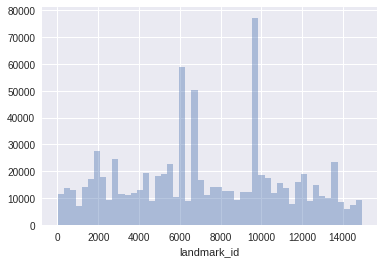

In [25]:
sns.distplot(input_data200['landmark_id'], kde=False)

In [0]:
VALID_EXEMPLES_PER_CLASS = 50
valid_ids = []
valid_y = []
for cs in ids_to_internal_map.values():
  valid_ids.extend(np.random.choice(
      input_data200[input_data200['internal_id'] == cs]['id'].values, 
      VALID_EXEMPLES_PER_CLASS,
      replace=False
  ))
  valid_y.extend([cs] * VALID_EXEMPLES_PER_CLASS)

valid_ids = np.array(valid_ids)
valid_y = np.array(valid_y)

In [0]:
train_ids, train_y = list(zip(*input_data200[~input_data200['id'].isin(valid_ids)][['id', 'internal_id']].values.tolist()))
train_ids = np.array(train_ids)
train_y = np.array(train_y)

In [0]:
from download_images import key_to_path
from gcs_wrapper import get_bucket
import multiprocessing.pool
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import time

from google.cloud import storage
PROJECT_NAME = 'trial-cloud-storage-19852'
client = storage.Client(PROJECT_NAME)

class DownFromGCS(object):

    def __init__(self):
        self.bucket = client.get_bucket(DOWNLOAD_BUCKET_NAME)

    def __call__(self, key):
        filename = key_to_path(key)
        blob = self.bucket.blob(filename)
        return (key, Image.open(BytesIO(blob.download_as_string())))
      
          
def get_image_for_ids(ids):
  with multiprocessing.pool.ThreadPool(processes=64) as pool:
    images = pool.map(DownFromGCS(), ids)
    pool.close()
    pool.terminate()
  return images

In [0]:
internal_classes, classes_counts = np.unique(train_y, return_counts=True)
classes_counts_sum = np.sum(classes_counts)
classes_choice_prob = dict(zip(internal_classes.tolist(), (classes_counts_sum/classes_counts).tolist()))
train_probs = [classes_choice_prob[y] for y in train_y]
train_probs_norm = np.array(train_probs) / sum(train_probs)
train_probs = train_probs_norm

#### Test probs

In [30]:
_, t = np.unique(np.random.choice(train_y, size=20000000, replace=True, p=train_probs), return_counts=True)
t.min(), t.max()

(17873, 18759)

In [31]:
_, t = np.unique(np.random.choice(valid_y, size=20000000, replace=True, p=None), return_counts=True)
t.min(), t.max()

(17885, 18711)

In [0]:
from queue import Queue
from threading import Thread

STOP_QUEUE = Queue(1)

class FetchData(object):
  
    def __init__(self, download_batch_size=1024, download_steps_per_epoch=5,
            batch_size=32, epochs=5):
        self.download_batch_size = download_batch_size
        self.download_steps_per_epoch = download_steps_per_epoch
        self.batch_size = batch_size
        self.epochs = epochs
        self.steps_per_epoch = int(download_steps_per_epoch * \
                download_batch_size / batch_size)

        
    def get_fit_config(self):
        return self.steps_per_epoch, self.epochs
     
    def stop(self):
        try:
          s = STOP_QUEUE.get(False)
        except:
          return False
        STOP_QUEUE.put(1)
        return True
    
  
    def produce(self, out_q, ids, y, probs=None, aug=None, sampling=True):
        for epoch_num in range(self.epochs):
          num_selected_ids = self.download_batch_size * self.download_steps_per_epoch
          if sampling:
            selected_indexes = np.random.choice(
                range(ids.shape[0]), 
                size=num_selected_ids,
                replace=True,
                p=probs,
            )
            selected_ids = ids[selected_indexes] 
            selected_y = y[selected_indexes]
          else:
            lower_bound = epoch_num * num_selected_ids
            upper_bound = (epoch_num + 1) * num_selected_ids
            selected_ids = ids[lower_bound: upper_bound]
            selected_y = y[lower_bound: upper_bound]
          for i in range(self.download_steps_per_epoch):
            batch_image_data = get_image_for_ids(
                selected_ids[i * self.download_batch_size: (i+1) * self.download_batch_size]
            )
    #         print([x for x, _ in batch_image_data[:20]])
    #         print(selected_ids[i * self.download_batch_size: (i+1) * self.download_batch_size][:20])
            batch_x = np.stack([np.asarray(x) for _, x in batch_image_data], 
                                  axis=0)
    #         print(batch_x.shape)
            batch_y = selected_y[i * self.download_batch_size: (i+1) * self.download_batch_size]
            splits = np.arange(self.batch_size, self.download_batch_size, self.batch_size)
            # TODO ADD IMAGE AUGMENTATION
            if aug:
              batch_x = aug.augment_images(batch_x)
#             batch_x = batch_x/255 - 0.5
            for _ret in zip(
                np.split(batch_x, splits, axis=0), 
                np.split(batch_y, splits, axis=0)
            ):
              if self.stop():
                print("STOPPED")
                return

              out_q.put(_ret)

In [0]:
EPOCHS = 10
DOWNLOAD_BATCH_SIZE = 2048

#### Create train producer

In [0]:
from imgaug import augmenters as iaa

train_aug = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-30, 30)),
    iaa.GaussianBlur(sigma=(0, 0.5))
])

In [0]:
# train producer
train_q = Queue(1024)
train_fetch = FetchData(
    download_batch_size=DOWNLOAD_BATCH_SIZE,
    download_steps_per_epoch=5,
    batch_size=16,
    epochs=EPOCHS
)
# train_fetch.produce(train_q, train_ids, train_y, train_probs)
train_thread = Thread(target=train_fetch.produce, 
        args=(train_q, train_ids, train_y, train_probs, train_aug))
train_thread.start()
# train_thread.join()

#### Create valid producer

In [0]:
# test producer
valid_q = Queue(1024)
valid_fetch = FetchData(
    download_batch_size=DOWNLOAD_BATCH_SIZE,
    download_steps_per_epoch=1,
    batch_size=16,
    epochs=EPOCHS
)

# valid_fetch.produce(valid_q, valid_ids, valid_y)
valid_thread = Thread(target=valid_fetch.produce, 
        args=(valid_q, valid_ids, valid_y))
valid_thread.start()
# valid_thread.join()

In [37]:
train_q.qsize(), valid_q.qsize()

(0, 0)

In [0]:
class DataGenerator:
    def __init__(self, q):
        self.q = q

    def __iter__(self):
        return self

    def __next__(self):
        X, y = self.q.get()
        return X, y

In [0]:
train_dg = DataGenerator(train_q)
valid_dg = DataGenerator(valid_q)

## Build Model

In [24]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout, Input, Flatten
from keras.models import Sequential, Model

Using TensorFlow backend.


In [0]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [26]:
input = Input(shape=(256,256,3),name = 'image_input')

resnet_output = resnet(input)

x = Flatten(name='flatten')(resnet_output)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(len(ids_to_internal_map), activation='softmax', name='predictions')(x)

my_model = Model(input=input, output=x)

my_model.layers[1].trainable = True

NameError: ignored

In [43]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 1092)              1119300   
Total params: 26,805,188
Trainable params: 26,752,068
Non-trainable params: 53,120
___________________________________________________________

In [34]:
from keras.optimizers import Adam, SGD
from keras.losses import sparse_categorical_crossentropy
cm = my_model.compile(
    optimizer=SGD(lr=0.03, momentum=0.2, decay=10e-5),
    loss=sparse_categorical_crossentropy,
    metrics=['acc']
)

Using TensorFlow backend.


NameError: ignored

In [0]:
from keras.models import load_model

def upload_model(model_name, model):
    model.save(model_name)
    model_blob = GLOBAL_BUCKET.blob('models/%s' % model_name)
    model_blob.upload_from_filename(model_name)
    os.remove(model_name)

def download_model(model_name):
    model_blob = GLOBAL_BUCKET.blob('models/%s' % model_name)
    model_blob.download_to_filename(model_name)
    model = load_model(model_name)
    os.remove(model_name)
    return model

/-classes, 200 examples per class

In [0]:
steps_per_epoch, epochs = train_fetch.get_fit_config()
valid_steps, _ = valid_fetch.get_fit_config()

my_model.fit_generator(train_dg, steps_per_epoch=steps_per_epoch, epochs=epochs,
        validation_data=valid_dg, validation_steps=valid_steps, 
        workers=0, max_queue_size=1000)

Epoch 1/10
372/640 [================>.............] - ETA: 3:29 - loss: 6.9254 - acc: 0.0106

640/640 [==============================] - 501s 783ms/step - loss: 6.7126 - acc: 0.0224 - val_loss: 6.1679 - val_acc: 0.0596
Epoch 2/10
  3/640 [..............................] - ETA: 10:34 - loss: 6.4170 - acc: 0.0208

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.830279). Check your callbacks.
  % delta_t_median)


493/640 [======================>.......] - ETA: 1:38 - loss: 5.3952 - acc: 0.1036

In [0]:
model_name = 'resnet50_200ex_10ep_av73_v2.md5'
my_model = download_model(model_name)

In [42]:
# serious eval
# test producer
valid_q = Queue(1024)
valid_fetch = FetchData(
    download_batch_size=DOWNLOAD_BATCH_SIZE,
    download_steps_per_epoch=200,
    batch_size=16,
    epochs=1
)

# valid_fetch.produce(valid_q, valid_ids, valid_y)
valid_thread = Thread(target=valid_fetch.produce, 
        args=(valid_q, valid_ids, valid_y))
valid_thread.start()
# valid_thread.join()

valid_dg = DataGenerator(valid_q)
valid_steps, _ = valid_fetch.get_fit_config()

print("Evaluating")
my_model.evaluate_generator(generator=valid_dg, steps=valid_steps, 
    max_queue_size=128, workers=0)

Evaluating


KeyboardInterrupt: ignored

In [0]:
model_name = 'resnet50_200ex_10ep_av73_v2.md5'
upload_model(model_name, my_model)

375 classes, 500 examples per class

In [0]:
steps_per_epoch, epochs = train_fetch.get_fit_config()
valid_steps, _ = valid_fetch.get_fit_config()

my_model.fit_generator(train_dg, steps_per_epoch=steps_per_epoch, epochs=epochs,
        validation_data=valid_dg, validation_steps=valid_steps, 
        workers=0, max_queue_size=1000)

Epoch 1/5
640/640 [==============================] - 449s 701ms/step - loss: 3.6752 - acc: 0.2950 - val_loss: 2.7592 - val_acc: 0.4102
Epoch 2/5
184/640 [=======>......................] - ETA: 5:00 - loss: 1.8654 - acc: 0.5720

640/640 [==============================] - 445s 695ms/step - loss: 1.6110 - acc: 0.6254 - val_loss: 3.0677 - val_acc: 0.3652
Epoch 3/5
290/640 [============>.................] - ETA: 3:47 - loss: 1.1993 - acc: 0.7181

640/640 [==============================] - 442s 691ms/step - loss: 1.1181 - acc: 0.7350 - val_loss: 1.4786 - val_acc: 0.6528
Epoch 4/5
330/640 [==============>...............] - ETA: 3:19 - loss: 0.9510 - acc: 0.7790

640/640 [==============================] - 444s 693ms/step - loss: 0.9214 - acc: 0.7858 - val_loss: 1.5226 - val_acc: 0.6475
Epoch 5/5
345/640 [===============>..............] - ETA: 3:09 - loss: 0.7561 - acc: 0.8139

640/640 [==============================] - 435s 680ms/step - loss: 0.7240 - acc: 0.8221 - val_loss: 1.2356 - val_acc: 0.7080


In [0]:
model_name = 'resnet50_500ex_5ep_av70.md5'
upload_model(model_name)

# STEP 2: USE FEATURE MAP FROM MODEL. TRAIN SVM 1vsALL

### Load encoder model

In [24]:
import keras.models
from keras import backend as K
from sklearn.decomposition import PCA

def download_model(model_name):
    local_file_name = 'encoding_model.md5'
    if not os.path.exists(local_file_name):
      model_blob = GLOBAL_BUCKET.blob('models/%s' % model_name)
      model_blob.download_to_filename(local_file_name)
    m = keras.models.load_model(local_file_name)
    return m

Using TensorFlow backend.


In [0]:
model_name = 'resnet50_200ex_10ep_av73_v2.md5'
model = download_model(model_name)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              2098176   
_________________________________________________________________
predictions (Dense)          (None, 1092)              1119300   
Total params: 26,805,188
Trainable params: 26,752,068
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
get_embedding_rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])

### Sampling

In [29]:
MIN_EXAMPLES = 10
print("Classes with more than %s images: %.2f%%" % (MIN_EXAMPLES, 
        (100 * (sum(imgs_per_class > MIN_EXAMPLES) / imgs_per_class.shape[0])))
)
print(sum(imgs_per_class > MIN_EXAMPLES))

Classes with more than 10 images: 55.97%
8368


In [30]:
imgs_per_class[imgs_per_class < MIN_EXAMPLES].sum()

33176

#### Create Train Set for ALL

In [29]:
MAX_EXAMPLES_PER_CLASS_ALL = 50
MIN_EXAMPLES_PER_CLASS_ALL = 1
FRACTION_OF_EXMAPLES_PER_CLASS = 0.1
# select classes
target_classes_all = imgs_per_class[imgs_per_class > 10].index
# pick examples from classes
all_examples = []
for tca in tqdm(target_classes_all):
  num_ex_to_pick = int(imgs_per_class[tca] * FRACTION_OF_EXMAPLES_PER_CLASS)
  num_ex_to_pick = max(num_ex_to_pick, MIN_EXAMPLES_PER_CLASS_ALL)
  num_ex_to_pick = min(num_ex_to_pick, MAX_EXAMPLES_PER_CLASS_ALL)
  class_ids = input_data[input_data['landmark_id'] == tca][['id', 'landmark_id']].values
  selected_index = np.random.choice(
      range(len(class_ids)),
      size = num_ex_to_pick,
      replace=False
  )
  all_examples.extend(class_ids[selected_index])
all_examples = np.array(all_examples)
all_examples.shape

100%|██████████| 14951/14951 [00:37<00:00, 403.44it/s]


In [0]:
# test producer
download_batch_size = 1024
all_q = Queue(1024)
all_fetch = FetchData(
    download_batch_size=download_batch_size,
    download_steps_per_epoch=int(all_examples.shape[0]/download_batch_size) + 1,
    batch_size=64,
    epochs=1
)

# all_fetch.produce(all_q, all_examples, np.zeros(all_examples.shape[0]), sampling=False)
all_thread = Thread(target=all_fetch.produce, 
        args=(all_q, all_examples[:, 0], np.zeros(all_examples.shape[0])), 
        kwargs={'sampling': False})
all_thread.start()
# valid_thread.join()



In [0]:
steps, _ = all_fetch.get_fit_config()
print(steps)
feature_maps = []
for i in tqdm(range(steps)):
  batch_imgs = all_q.get()[0]
  feature_maps.append(get_embedding_rd_layer_output([batch_imgs])[0])
feature_maps = np.concatenate(feature_maps, axis=0)
feature_maps.shape, all_examples.shape

  0%|          | 0/3888 [00:00<?, ?it/s]

3888


 21%|██        | 813/3888 [12:29<47:15,  1.08it/s]

In [0]:
#upload feature maps for all class
with open('feature_maps.f', 'wb') as f:
  pickle.dump((all_examples, feature_maps), f)
fmblob = GLOBAL_BUCKET.blob('all_feature_maps.ft')
fmblob.upload_from_filename('feature_maps.f')

In [0]:
#download feature maps for all class
fmblob = GLOBAL_BUCKET.blob('all_feature_maps.ft')
all_feature_maps = fmblob.download_to_filename('feature_maps.f')
with open('feature_maps.f', 'rb') as f:
  all_examples, feature_maps = pickle.load(f)

In [29]:
from annoy import AnnoyIndex
NUM_TREES = 256

index = AnnoyIndex(feature_maps.shape[1])
for f, iid in tqdm(zip(feature_maps, np.arange(all_examples.shape[0]))):
  index.add_item(iid, f)
index.build(NUM_TREES)

73020it [00:09, 8004.03it/s]


True

In [30]:
results = []
for iid, f_vector in tqdm(enumerate(feature_maps)):
  res = index.get_nns_by_vector(f_vector, 6, search_k=-1, include_distances=True)
  results.append(res)

73020it [01:28, 824.72it/s]


In [31]:
from collections import Counter
def class_knn(l):
  c = Counter()
  for el in l:
    c[el] += 1
  return sorted(c.items(), key = lambda x: -x[1])[0][0]
  

correct_distances = []
wrong_distances = []
correct_classifications = 0
for res in tqdm(results):
  indexes, distances = res
  local_ex = all_examples[indexes, :]
  images_ids = local_ex[:, 0]
  labels = local_ex[:, 1]
  correct_distances.extend([d for d,l in zip(distances[1:], labels[1:]) if l == labels[0]]) 
  wrong_distances.extend([d for d,l in zip(distances[1:], labels[1:]) if l != labels[0]]) 
  correct_classifications += 1 if class_knn(labels[1:]) == labels[0] else 0
#   print('\n'.join(list(map(str, zip(indexes, distances, images_ids, labels)))))


100%|██████████| 73020/73020 [00:01<00:00, 39739.89it/s]


In [33]:
print("Cassification ACC using 5-nn: %s" % (correct_classifications / len(results)))

Cassification ACC using 5-nn: 0.6666529717885511


In [34]:
print(min(correct_distances), max(correct_distances))
print(min(wrong_distances), max(wrong_distances))

0.14543017745018005 0.8582074642181396
0.0 0.8915014863014221


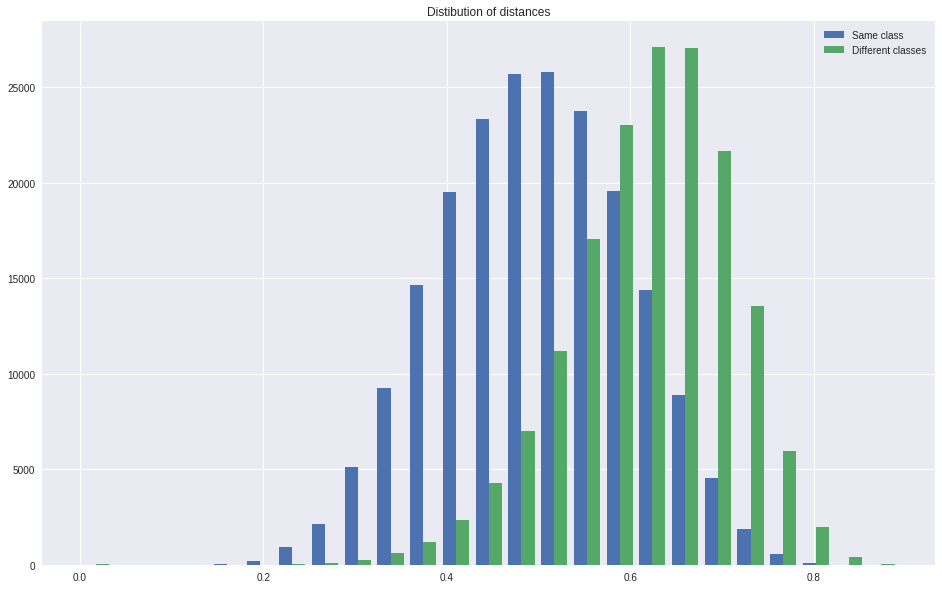

In [35]:
plt.figure(figsize=(16, 10))
plt.hist((correct_distances, wrong_distances), bins=25)
plt.title('Distibution of distances')
plt.legend(['Same class', 'Different classes'])

In [36]:
accs = {}
for tresh in np.arange(0.5, 0.8, 0.01):
  n_w = len(list(filter(lambda x: x>tresh, correct_distances))) + len(list(filter(lambda x: x < tresh, wrong_distances)))
  accs[tresh] = 1 - n_w / (len(correct_distances) + len(wrong_distances))                                                             
#   (len(correct_distances) + len(wrong_distances)) - n_w, n_w, 1 - n_w / (len(correct_distances) + len(wrong_distances))                                                             
accs

{0.5: 0.6851081895371132,
 0.51: 0.697940290331416,
 0.52: 0.7097589701451656,
 0.53: 0.7198301835113667,
 0.54: 0.7285784716516023,
 0.55: 0.7350424541221583,
 0.56: 0.739860312243221,
 0.5700000000000001: 0.7425089016707751,
 0.5800000000000001: 0.7428375787455492,
 0.5900000000000001: 0.7413366201040811,
 0.6000000000000001: 0.7368940016433854,
 0.6100000000000001: 0.7308408655162969,
 0.6200000000000001: 0.7223336072308957,
 0.6300000000000001: 0.7124568611339359,
 0.6400000000000001: 0.7006025746370858,
 0.6500000000000001: 0.6876910435497123,
 0.6600000000000001: 0.6742810188989318,
 0.6700000000000002: 0.6597480142426733,
 0.6800000000000002: 0.6453108737332238,
 0.6900000000000002: 0.6310161599561763,
 0.7000000000000002: 0.6177759517940291,
 0.7100000000000002: 0.6052889619282389,
 0.7200000000000002: 0.594426184606957,
 0.7300000000000002: 0.5843631881676252,
 0.7400000000000002: 0.5761955628594906,
 0.7500000000000002: 0.5691700903861956,
 0.7600000000000002: 0.5635634072856

## Image retrieval examples

In [0]:
img_index = 53422
# img_index = 53425
res = index.get_nns_by_vector(feature_maps[img_index], 6, search_k=-1, include_distances=False)

In [0]:
# train producer
aug_q = Queue(1)
aug_fetch = FetchData(
    download_batch_size=len(res),
    download_steps_per_epoch=1,
    batch_size=len(res),
    epochs=1
)
data_to_fetch = all_examples[res, :]
aug_fetch.produce(aug_q, data_to_fetch[:,0], data_to_fetch[:, 1], None, sampling=False)
aug_images, aug_lables = aug_q.get()

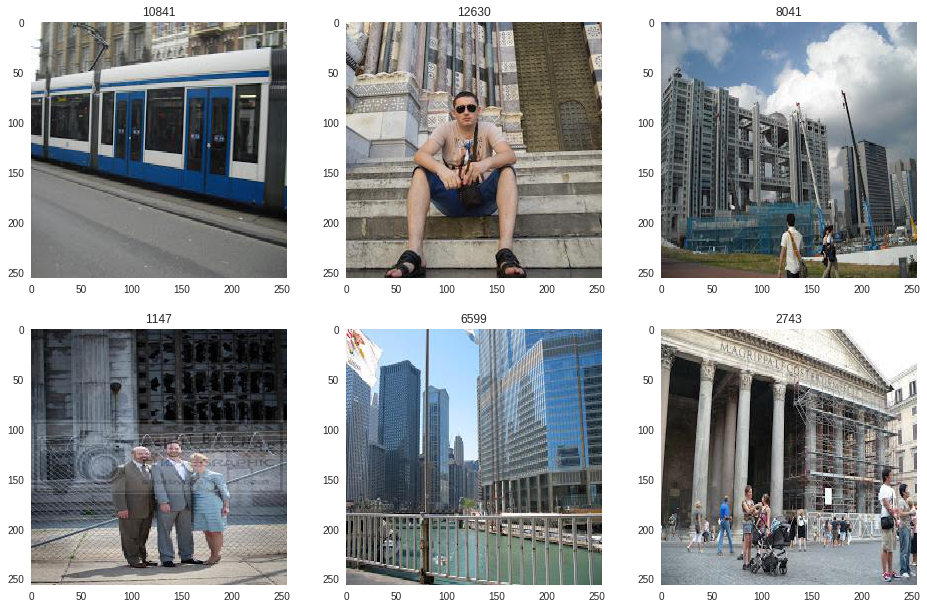

In [62]:
plt.figure(figsize=(16,16))
for i, (img, label) in enumerate(zip(aug_images,aug_lables)):
  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  plt.title(label)
  plt.grid(False)

# Experiments

In [31]:
MAX_EXAMPLES_PER_CLASS_ALL = 15
MIN_EXAMPLES_PER_CLASS_ALL = 1
FRACTION_OF_EXMAPLES_PER_CLASS = 1
# select classes
target_classes_all = imgs_per_class.index
# pick examples from classes
all_examples = []
for tca in tqdm(target_classes_all):
  num_ex_to_pick = int(imgs_per_class[tca] * FRACTION_OF_EXMAPLES_PER_CLASS)
  num_ex_to_pick = max(num_ex_to_pick, MIN_EXAMPLES_PER_CLASS_ALL)
  num_ex_to_pick = min(num_ex_to_pick, MAX_EXAMPLES_PER_CLASS_ALL)
  class_ids = input_data[input_data['landmark_id'] == tca][['id', 'landmark_id']].values
  selected_index = np.random.choice(
      range(len(class_ids)),
      size = num_ex_to_pick,
      replace=False
  )
  all_examples.extend(class_ids[selected_index])
all_examples = np.array(all_examples)
all_examples.shape

100%|██████████| 14951/14951 [00:35<00:00, 418.02it/s]


(159788, 2)

In [0]:
# test producer
download_batch_size = 1024
all_q = Queue(1024)
all_fetch = FetchData(
    download_batch_size=download_batch_size,
    download_steps_per_epoch=int(all_examples.shape[0]/download_batch_size) + 1,
    batch_size=64,
    epochs=1
)

# all_fetch.produce(all_q, all_examples, np.zeros(all_examples.shape[0]), sampling=False)
all_thread = Thread(target=all_fetch.produce, 
        args=(all_q, all_examples[:, 0], np.zeros(all_examples.shape[0])), 
        kwargs={'sampling': False})
all_thread.start()
# valid_thread.join()



In [0]:
steps, _ = all_fetch.get_fit_config()
print(steps)
feature_maps = []
for i in tqdm(range(steps)):
  batch_imgs = all_q.get()[0]
  feature_maps.append(get_embedding_rd_layer_output([batch_imgs])[0])
feature_maps = np.concatenate(feature_maps, axis=0)
feature_maps.shape, all_examples.shape

  0%|          | 0/2512 [00:00<?, ?it/s]

2512


 35%|███▌      | 887/2512 [13:45<25:13,  1.07it/s]

In [0]:
#upload feature maps for all class
with open('feature_maps_v2.f', 'wb') as f:
  pickle.dump((all_examples, feature_maps), f)
fmblob = GLOBAL_BUCKET.blob('all_feature_maps_v2.ft')
fmblob.upload_from_filename('feature_maps_v2.f')

In [0]:
#download feature maps for all class
fmblob = GLOBAL_BUCKET.blob('all_feature_maps_v2.ft')
all_feature_maps = fmblob.download_to_filename('feature_maps_v2.f')
with open('feature_maps_v2.f', 'rb') as f:
  all_examples, feature_maps = pickle.load(f)

In [0]:
!pip install imgaug

    100% |████████████████████████████████| 563kB 1.8MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /content/.cache/pip/wheels/7e/a1/8d/539b1e9c828007360ec8684168a0b368e79bee302cef062c8e
Successfully built imgaug


In [0]:
# train producer
aug_q = Queue(1024)
aug_fetch = FetchData(
    download_batch_size=27,
    download_steps_per_epoch=1,
    batch_size=27,
    epochs=1
)
aug_fetch.produce(aug_q, np.array(all_examples[:27]), np.arange(27), None)
aug_images, aug_lables = aug_q.get()

In [33]:
aug_images.shape

(27, 256, 256, 3)

In [0]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Affine(rotate=(-30, 30)),
    iaa.Sometimes(0.5,
        [iaa.Crop(px=(0, 64))],
        [iaa.Pad(px=(0,64))]
    ),
    iaa.GaussianBlur(sigma=(0, 0.5)), # blur images with a sigma of 0 to 3.0
    iaa.Sometimes(0.2, [iaa.PerspectiveTransform(0.1)]),
])

# 'images' should be either a 4D numpy array of shape (N, height, width, channels)
# or a list of 3D numpy arrays, each having shape (height, width, channels).
# Grayscale images must have shape (height, width, 1) each.
# All images must have numpy's dtype uint8. Values are expected to be in
# range 0-255.
images_aug = seq.augment_images(aug_images)


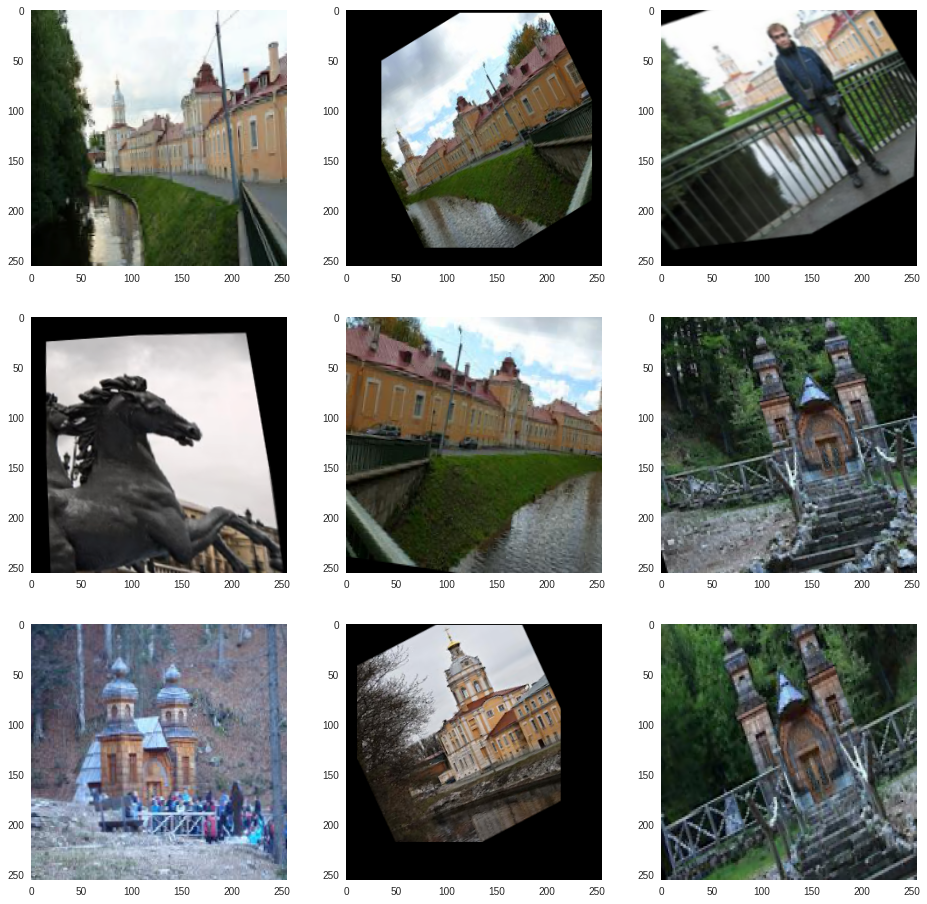

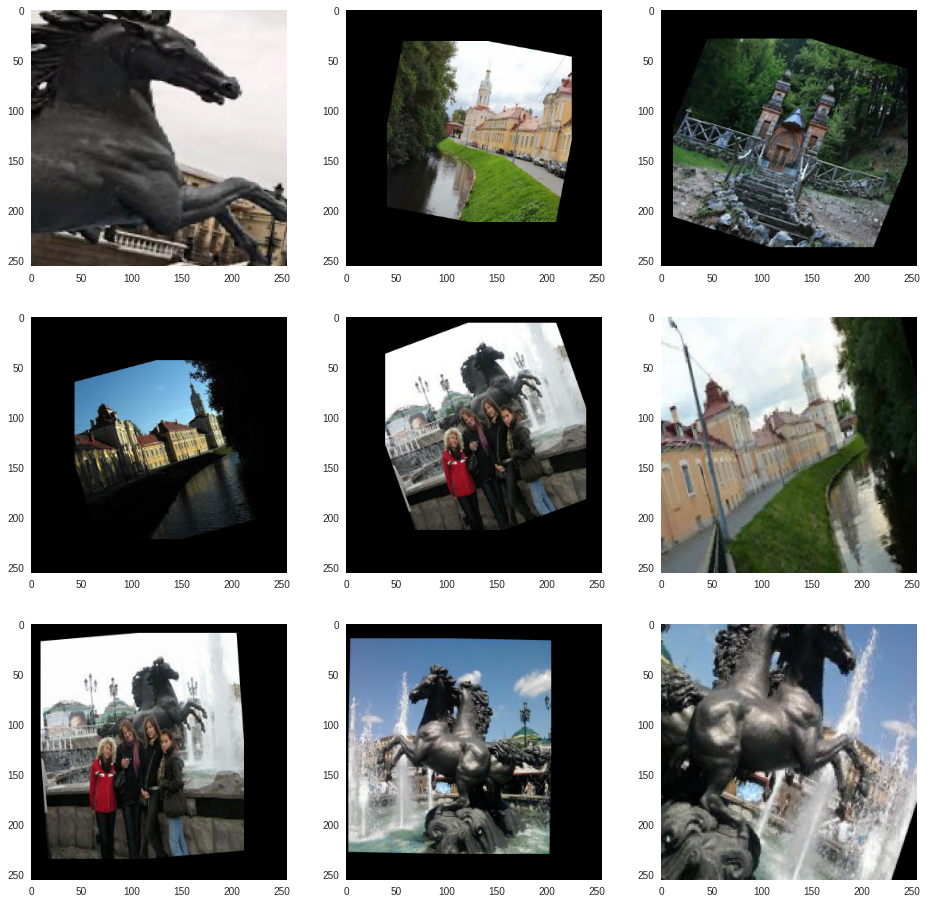

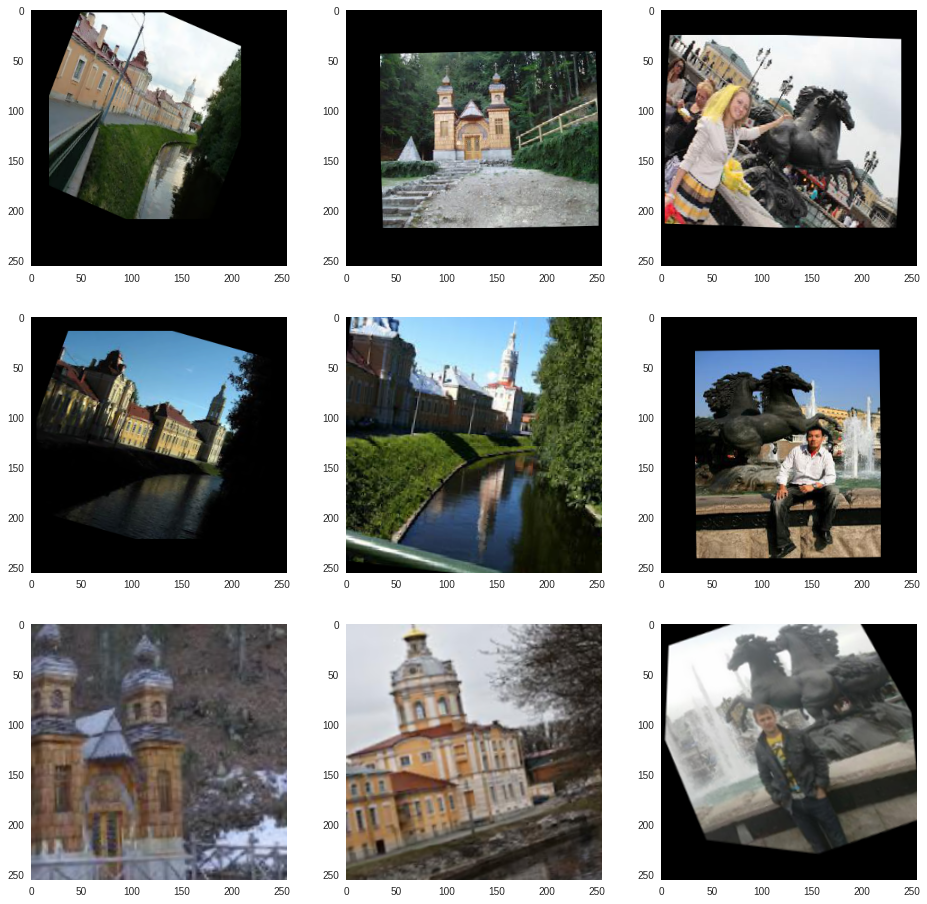

In [35]:
for j in range(3):
  plt.figure(figsize=(16, 16))
  for i,img in enumerate(images_aug[j*9:(j+1)*9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.grid(False)